In [1]:
# Step 5: Customer Segmentation using K-Means Clustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Load the RFM data
rfm = pd.read_csv('../data/processed/rfm_data.csv')
print("RFM data loaded successfully!")
print(f"Dataset shape: {rfm.shape}")
rfm.head()

RFM data loaded successfully!
Dataset shape: (4303, 9)


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12347.0,2,7,4060.40,4,4,4,444,12
1,12348.0,75,4,1195.08,2,3,3,233,8
2,12349.0,19,1,1757.55,3,1,4,314,8
3,12350.0,310,1,334.40,1,1,2,112,4
4,12352.0,36,8,2506.04,3,4,4,344,11


# Prepare Data for Clustering

In [2]:
# Select only the RFM metrics for clustering (exclude scores and CustomerID)
X = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Check distributions - clustering is sensitive to scale
print("=== RFM METRICS DISTRIBUTION ===")
print(X.describe())

# Log transformation for Monetary and Frequency (they're highly skewed)
X['Frequency_log'] = np.log1p(X['Frequency'])
X['Monetary_log'] = np.log1p(X['Monetary'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['Recency', 'Frequency_log', 'Monetary_log']])
X_scaled_df = pd.DataFrame(X_scaled, columns=['Recency', 'Frequency_log', 'Monetary_log'])

print("\nData prepared for clustering!")
print("Shape after preprocessing:", X_scaled_df.shape)

=== RFM METRICS DISTRIBUTION ===
           Recency    Frequency       Monetary
count  4303.000000  4303.000000    4303.000000
mean     92.686265     4.212875    1649.905188
std     100.051319     7.524221    4854.086800
min       1.000000     1.000000       2.900000
25%      18.000000     1.000000     298.055000
50%      51.000000     2.000000     646.830000
75%     143.000000     5.000000    1583.260000
max     374.000000   209.000000  152712.600000

Data prepared for clustering!
Shape after preprocessing: (4303, 3)


# Determine Optimal Number of Clusters

###  Determining Optimal Number of Clusters

We use two methods to determine the optimal number of clusters:
1. **Elbow Method:** Looks for the "elbow" point where adding more clusters doesn't significantly reduce WCSS
2. **Silhouette Score:** Measures how similar points are to their own cluster vs other clusters (higher is better, range -1 to 1)

Based on your business needs (actionable segments), we typically choose 4-6 clusters for customer segmentation.

  File "C:\Users\ssaja\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\ssaja\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ssaja\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ssaja\anaconda3\Lib\subprocess.

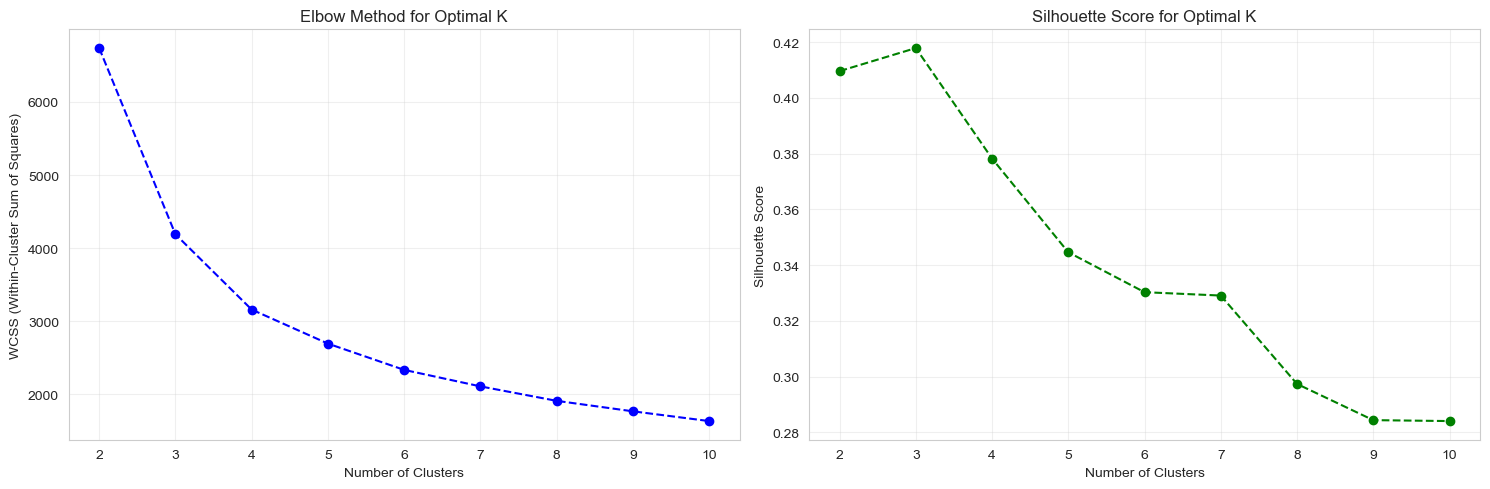

Silhouette Scores:
K=2: 0.410
K=3: 0.418
K=4: 0.378
K=5: 0.345
K=6: 0.330
K=7: 0.329
K=8: 0.297
K=9: 0.284
K=10: 0.284


In [3]:
# Method 1: Elbow Method
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    if k > 1:  # Silhouette score needs at least 2 clusters
        score = silhouette_score(X_scaled_df, kmeans.labels_)
        silhouette_scores.append(score)

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o', linestyle='--', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(range(2, 11))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print silhouette scores for decision making
print("Silhouette Scores:")
for k, score in zip(range(2, 11), silhouette_scores):
    print(f"K={k}: {score:.3f}")

# Apply K-Means Clustering

In [4]:
# Choose optimal K (typically 4-5 for customer segmentation)
optimal_k = 4  # You can adjust this based on elbow and silhouette plots

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled_df)

print(f"Clustering complete with {optimal_k} clusters!")
print("\nCluster Distribution:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
print(cluster_counts)

# Add cluster centers back to original scale for interpretation
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, 
                                  columns=['Recency', 'Frequency_log', 'Monetary_log'])

# Convert log values back to original scale
cluster_centers_df['Frequency'] = np.expm1(cluster_centers_df['Frequency_log'])
cluster_centers_df['Monetary'] = np.expm1(cluster_centers_df['Monetary_log'])

print("\nCluster Centers (approximate values):")
print(cluster_centers_df[['Recency', 'Frequency', 'Monetary']])

Clustering complete with 4 clusters!

Cluster Distribution:
Cluster
0     624
1    1330
2     927
3    1422
Name: count, dtype: int64

Cluster Centers (approximate values):
      Recency  Frequency     Monetary
0   20.115016  12.158008  4550.247184
1   58.680211   1.411114   294.128740
2  260.186624   1.282822   262.203617
3   47.190711   3.783993  1242.292705


# Analyze and Profile Clusters

=== CLUSTER PROFILES ===
         Recency  Frequency  Monetary  Count  Percentage
Cluster                                                 
0          20.11      14.72   6775.07    624        14.5
1          58.64       1.49    359.71   1330        30.9
2         260.19       1.36    362.38    927        21.5
3          47.18       4.01   1446.95   1422        33.0


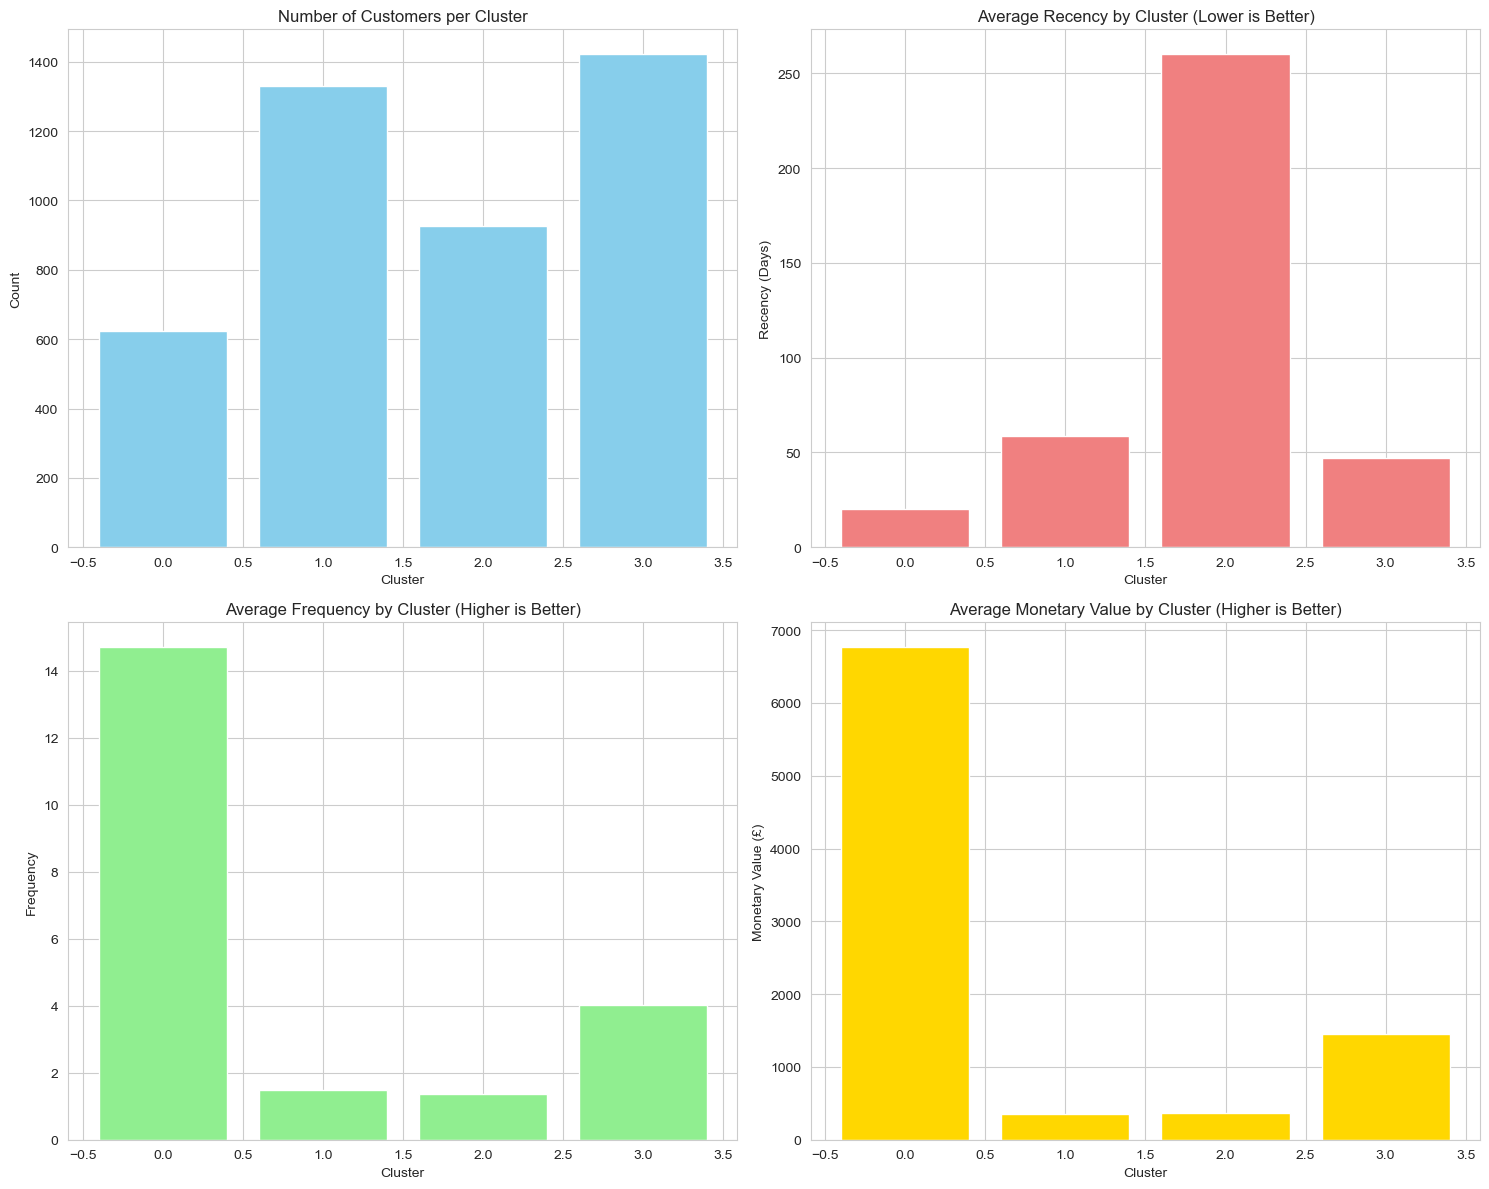

In [8]:
# Analyze each cluster's characteristics
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).round(2)

cluster_profile = cluster_profile.rename(columns={'Customer ID': 'Count'})
cluster_profile['Percentage'] = (cluster_profile['Count'] / len(rfm) * 100).round(1)

print("=== CLUSTER PROFILES ===")
print(cluster_profile)

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cluster sizes
axes[0, 0].bar(cluster_profile.index, cluster_profile['Count'], color='skyblue')
axes[0, 0].set_title('Number of Customers per Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Count')

# Recency by cluster
axes[0, 1].bar(cluster_profile.index, cluster_profile['Recency'], color='lightcoral')
axes[0, 1].set_title('Average Recency by Cluster (Lower is Better)')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Recency (Days)')

# Frequency by cluster
axes[1, 0].bar(cluster_profile.index, cluster_profile['Frequency'], color='lightgreen')
axes[1, 0].set_title('Average Frequency by Cluster (Higher is Better)')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Frequency')

# Monetary by cluster
axes[1, 1].bar(cluster_profile.index, cluster_profile['Monetary'], color='gold')
axes[1, 1].set_title('Average Monetary Value by Cluster (Higher is Better)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Monetary Value (£)')

plt.tight_layout()
plt.show()

# Interpret Clusters and Assign Business Names

In [9]:
# Based on cluster profiles, assign meaningful names
def name_clusters(cluster_profile):
    cluster_names = {}
    
    for cluster in cluster_profile.index:
        recency = cluster_profile.loc[cluster, 'Recency']
        frequency = cluster_profile.loc[cluster, 'Frequency']
        monetary = cluster_profile.loc[cluster, 'Monetary']
        
        # Define naming logic based on RFM values
        if recency < 50 and frequency > 5 and monetary > 2000:
            name = 'Champions'
        elif recency < 100 and frequency > 3 and monetary > 1000:
            name = 'Loyal Customers'
        elif recency < 150 and monetary > 500:
            name = 'Potential Loyalists'
        elif recency > 200:
            name = 'At Risk'
        elif monetary < 300:
            name = 'Price Sensitive'
        elif frequency < 2:
            name = 'New Customers'
        else:
            name = f'Cluster {cluster}'
            
        cluster_names[cluster] = name
    
    return cluster_names

cluster_names = name_clusters(cluster_profile)
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

print("=== CLUSTER NAMES ASSIGNED ===")
for cluster, name in cluster_names.items():
    count = cluster_profile.loc[cluster, 'Count']
    pct = cluster_profile.loc[cluster, 'Percentage']
    recency = cluster_profile.loc[cluster, 'Recency']
    monetary = cluster_profile.loc[cluster, 'Monetary']
    print(f"Cluster {cluster}: {name} ({count} customers, {pct}%)")
    print(f"   Avg Recency: {recency:.0f} days, Avg Spend: £{monetary:,.0f}")
    print()

=== CLUSTER NAMES ASSIGNED ===
Cluster 0: Champions (624 customers, 14.5%)
   Avg Recency: 20 days, Avg Spend: £6,775

Cluster 1: New Customers (1330 customers, 30.9%)
   Avg Recency: 59 days, Avg Spend: £360

Cluster 2: At Risk (927 customers, 21.5%)
   Avg Recency: 260 days, Avg Spend: £362

Cluster 3: Loyal Customers (1422 customers, 33.0%)
   Avg Recency: 47 days, Avg Spend: £1,447



# Save Results

In [10]:
# Save the clustered data
rfm.to_csv('../data/processed/rfm_clustered.csv', index=False)

print("Clustered data saved to '../data/processed/rfm_clustered.csv'")
print("\n=== MODELING COMPLETE ===")
print(f"Customers successfully segmented into {optimal_k} distinct groups")
print("Ready for business interpretation and recommendation development!")

Clustered data saved to '../data/processed/rfm_clustered.csv'

=== MODELING COMPLETE ===
Customers successfully segmented into 4 distinct groups
Ready for business interpretation and recommendation development!
